# Transfer Learning - Fashion MNIST

Transfer Learning allows us to learn faster from a pre-trained model (on a similiar problem) by getting the feature transformation part

There are two ways to do this
- Get the prediction from the feature transformer and use that as an input to a new classifier.
- Make the feature transformation from the pre-trained model false and only train the classifier.

In [2]:
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import vis

### Get Data 

In [3]:
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [4]:
labels = vis.fashion_mnist_label()

**Step 1: Prepare the images and labels**

In [8]:
# Reshape data for convlution netowkr
x_train_conv = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test_conv = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

# Convert from 'uint8' to 'float32' and normalise the data to (0,1) 
x_train_conv =  x_train_conv.astype("float32") / 255
x_test_conv = x_test_conv.astype("float32") / 255

# convert class vectors to binary class matrices
y_train_class = tf.keras.utils.to_categorical(y_train, 10)
y_test_class = tf.keras.utils.to_categorical(y_test, 10)

Resize the image for the transfer learning model

Lets resize the image from (28,28,1) to (48,48,3)

In [9]:
from skimage.transform import resize

In [10]:
def resize_image(image):
    return resize(image, (96,96,3), mode="symmetric")

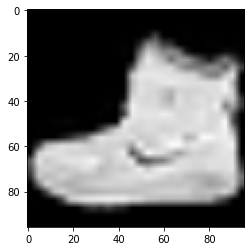

In [11]:
plt.imshow(resize_image(x_train_conv[0]));

Lets resize the 10000 images in train and test data

In [12]:
%timeit
x_train_conv_resize = np.array([resize_image(x_train_conv[x]) for x in range(x_train_conv[:10000].shape[0])])
x_train_conv_resize.shape

(10000, 96, 96, 3)

In [13]:
%timeit
x_test_conv_resize = np.array([resize_image(x_test_conv[x]) for x in range(x_test_conv.shape[0])])
x_test_conv_resize.shape

(10000, 96, 96, 3)

**Step 2: Load a pre-trained model for the feature transfomation and add classifier model **

Let us load the VGG model without the classifier layer and **do not** train the weights

In [14]:
from keras.applications.vgg16 import VGG16

In [15]:
conv_base = VGG16(include_top=False, weights='imagenet', 
                        input_tensor=None, input_shape=(96,96,3), pooling="avg")

58900480/58889256 [==============================] - 4s 0us/step


In [16]:
conv_base.trainable = False

In [17]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

In [18]:
size = 1000

In [19]:
x_train_conv_resize_vgg = conv_base.predict(x_train_conv_resize[:size])

In [20]:
x_test_conv_resize_vgg = conv_base.predict(x_test_conv_resize)

In [21]:
y_train_class_vgg = y_train_class[:size]

In [22]:
x_train_conv_resize_vgg.shape

(1000, 512)

Lets build a Dense Layer Classifier after that to classify the fashion mnist data

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [24]:
model_transfer = Sequential()
model_transfer.add(Dense(128, input_dim=512, activation='relu'))
model_transfer.add(Dropout(0.25))
model_transfer.add(Dense(64, activation='relu'))
model_transfer.add(Dense(10, activation='softmax'))

In [25]:
model_transfer.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 74,570
Trainable params: 74,570
Non-trainable params: 0
_________________________________________________________________


**Step 3: Compile and fit the model**

In [26]:
model_transfer.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [27]:
%time
output_transfer = model_transfer.fit(x_train_conv_resize_vgg, y_train_class_vgg, 
                                      batch_size=16, epochs=5, verbose=1, validation_split = 0.2)

Wall time: 0 ns
Epoch 1/5
50/50 [==============================] - 1s 5ms/step - loss: 2.0920 - accuracy: 0.2700 - val_loss: 1.6628 - val_accuracy: 0.5250
Epoch 2/5
50/50 [==============================] - 0s 2ms/step - loss: 1.4116 - accuracy: 0.5213 - val_loss: 1.1128 - val_accuracy: 0.6300
Epoch 3/5
50/50 [==============================] - 0s 2ms/step - loss: 0.9978 - accuracy: 0.6637 - val_loss: 0.8374 - val_accuracy: 0.6850
Epoch 4/5
50/50 [==============================] - 0s 2ms/step - loss: 0.8076 - accuracy: 0.7025 - val_loss: 0.6909 - val_accuracy: 0.7500
Epoch 5/5
50/50 [==============================] - 0s 2ms/step - loss: 0.7245 - accuracy: 0.7337 - val_loss: 0.6402 - val_accuracy: 0.7900


**Step 4: Check the performance of the model**

In [28]:
vis.metrics(output_transfer.history)

alt.FacetChart(...)

In [30]:
# score = model_transfer.evaluate(x_test_conv_reshape_vgg, y_test_class, verbose=1)
score = model_transfer.evaluate(x_test_conv_resize_vgg, y_test_class, verbose=1)


313/313 [==============================] - 0s 888us/step - loss: 0.6877 - accuracy: 0.7748


In [31]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6877223253250122
Test accuracy: 0.7748000025749207


**Step 5: Make & Visualise the Prediction**

In [35]:
# predict_classes_transfer = model_transfer.predict_classes(x_test_conv_reshape_vgg)
predict_classes = model_transfer.predict(x_test_conv_resize_vgg)
predict_classes_transfer = np.argmax(predict_classes,axis=1)

In [37]:
import pandas as pd
pd.crosstab(y_test, predict_classes_transfer)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,651,1,19,108,7,1,181,0,19,13
1,1,928,6,56,1,0,8,0,0,0
2,13,0,640,20,178,0,146,0,3,0
3,30,36,20,788,57,0,61,0,6,2
4,4,1,85,101,700,0,108,0,1,0
5,0,0,0,0,0,859,0,88,3,50
6,121,1,80,86,166,2,526,0,12,6
7,0,0,0,0,0,59,0,793,0,148
8,12,2,0,23,10,14,20,5,902,12


In [41]:
# proba_transfer = model_transfer_conv.predict_proba(x_test_conv_reshape_vgg)
predict_prob = model_transfer.predict(x_test_conv_resize_vgg)
proba_transfer = np.argmax(predict_prob,axis=1)

In [54]:
vis.imshow(x_test[i], labels[y_test[i]]) | vis.predict(proba_transfer[i], y_test[i], labels)

NameError: name 'i' is not defined

In [79]:
vis.predict(proba_transfer[:20], y_test[:20], labels)

alt.Chart(...)